<center><h1>Training models on the static features</h1></center>

This model and the features it uses are inspired by [this](https://ieeexplore.ieee.org/document/6512793) paper.
<br>Reference: T. Seehapoch and S. Wongthanavasu, "Speech emotion recognition using Support Vector Machines," 2013 5th International Conference on Knowledge and Smart Technology (KST), 2013, pp. 86-91, doi: 10.1109/KST.2013.6512793.


[Support Vector Machine](#svm)<br>
[Random Forest](#rf)<br>
[K-Nearest Neighbours](#knn)<br>
[Deep Neural Networks](#dnn)<br>

In [499]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import os

In [500]:
train_df = pd.read_csv("challengeA_data/2022challengeA_train_modified.csv", index_col=[0])

In [501]:
ext_features_df = pd.read_csv("challengeA_data/ext_features.csv", index_col=[0])
ext_features_df = ext_features_df.sample(frac=1).reset_index(drop=True)

In [502]:
ext_features_df.head()

,file_id,encoded_emotion,rms_max,rms_std,rms_mean,magnitude_max,magnitude_std,magnitude_mean,zero_crossing_rate,contrast_6,...,mfcc_mean_0,flatness,cent_max,cent_std,cent_mean,f0_mean,pitch_min,pitch_max,pitch_std,pitch_mean
0,8f5f0f6c-e6b1-4603-afa6-e7176155c7f3.wav,1,0.023380,0.004144,0.005611,5.437861,0.152714,0.044005,0.079567,14.065644,...,-387.79260,0.018255,0.034096,0.006166,0.011765,165.138863,0.0,108.85178,44.747290,31.372272
1,12bb7625-46ce-4b76-8886-a92da273e394.wav,1,0.029089,0.008324,0.008068,5.872895,0.252164,0.070545,0.237549,30.046667,...,-397.66226,0.048525,0.028606,0.007406,0.012500,550.054129,0.0,233.07109,87.927536,44.962154
2,8072d9fe-6d8d-4789-9f9c-387260ebdce9.wav,4,0.080704,0.014806,0.015661,18.152110,0.474969,0.107434,0.071442,14.644104,...,-342.10333,0.014104,0.033310,0.005524,0.012500,136.590338,0.0,233.78384,108.888115,127.943010
3,dca54fbd-6a56-4bb6-85dc-40af591eec1a.wav,2,0.023229,0.003963,0.004630,5.122289,0.132685,0.036798,0.084008,16.124706,...,-423.92975,0.027967,0.034681,0.006787,0.011905,139.477979,0.0,171.74686,57.297115,24.280186
4,fa2cdb22-8344-4fda-91a7-1731a53c6d74.wav,5,0.021989,0.005699,0.007034,5.799113,0.202475,0.034168,0.104348,29.361339,...,-520.40960,0.016901,0.039005,0.010130,0.012346,477.912233,0.0,294.64500,37.794910,5.203894


In [503]:
# include all features except for the file_id and the label
features_to_include = ext_features_df.columns[~ext_features_df.columns.isin(["encoded_emotion", "file_id"])]
labels = ext_features_df[["encoded_emotion"]].to_numpy() # shape is (num_instances, 1)
labels = labels.ravel() # flattens array, yielding shape (num_instances)
features = ext_features_df[features_to_include].to_numpy() # shape is (num_instances, num_features)

I need to normalize the features because a support vector machine is a distance-based algorithm and is thus sensitive to varying scales. 

In [504]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

I'll also create a training and testing dataset for fitting the models and making predictions to create confusion matrixes.

In [505]:
x_train, x_test, y_train, y_test  = train_test_split(scaled_features, labels, test_size=0.2)

In [181]:
model_scores = {}

In [506]:
emotions = sorted(list(train_df["emotion"].unique()))
num_emotions = len(emotions)

keys = emotions
values = np.arange(7)
emotion_encoder = dict(zip(keys, values))
print(emotion_encoder)
print("\n")
emotion_decoder = dict(zip(list(emotion_encoder.values()), list(emotion_encoder.keys())))
print(emotion_decoder)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sadness': 5, 'surprise': 6}


{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sadness', 6: 'surprise'}


In [485]:
def get_confusion_matrix(truth, predictions):
    """Returns the confusion matrix given predictions made by a model and the corresponding truth values.
        predictions: array of integers
        truth: array of integers
    """
    cm = confusion_matrix(truth, predictions)
    return cm

def get_accuracy_by_class(cm, labels):
    """Returns a dictionary with the labels as keys and the accuracy of predictions made by a model as values.
        confusion_matrix: 2D confusion matrix
        labels: list of class names – in this case, emotions
    """
    accuracy_by_class = cm.diagonal() / cm.sum(axis=1)
    accuracy_by_class = [round(acc, 2) for acc in accuracy_by_class]
    class_accuracy_dict = dict(zip(emotions, accuracy_by_class))
    return class_accuracy_dict
    
def show_confusion_matrix(cm):
    """Takes in predictions and the truth as arrays of scalars to create a confusion matrix. The
        confusion matrix is then displayed using seaborn. 
        predictions: array of integers
        truth: array of integers
    """
    plt.figure(figsize=(10, 7))
    ax = sns.heatmap(cm, annot=True, fmt="",
                    xticklabels=list(emotion_decoder.values()),
                    yticklabels=list(emotion_decoder.values()))
    plt.xlabel("Predicted", fontsize=10, labelpad=5)
    plt.ylabel("Truth", fontsize=10, labelpad=5)

def validate(est, X, y, split, fold_index, verbose):
    """Fits an estimator model and evaluates its performance.
        est - Estimator/Model
        X - training data
        y - validation data
        split - tuple of indices, where the first item is the training indices; the second the validation indices.
        verbose - if set to true, print when job is complete.
    """
    x_train, y_train = X[split[0], :], y[split[0]]
    x_val, y_val = X[split[1], :], y[split[1]]
    
    est.fit(x_train, y_train)
    
    y_pred = est.predict(x_val)
    
    metrics = {}
    metrics["accuracy"] = accuracy_score(y_val, y_pred)
    # f1-scores for each individual class: returns an array
    f1_individual_scores = f1_score(y_val, y_pred, average=None) 
    for i, f1_individual_score in enumerate(f1_individual_scores):
        metrics[f"f1_{emotions[i]}"] = f1_individual_score
    # aggregates the contributions of each class, then computes the f1-score, thus not favouring any one class.
    metrics["f1_micro"] = f1_score(y_val, y_pred, average="micro") 
    # Computes the f1-score for each class, then weights them by how frequently they appeared, returning
    # a single score.
    metrics["f1_weighted"] = f1_score(y_val, y_pred, average="weighted")
    # Computes the f1-score for each class and then gets their average.
    metrics["f1_macro"] = f1_score(y_val, y_pred, average="macro") # same as f1_individual.mean()
    
    if verbose: 
        print(f"Completed job {fold_index}")
    return pd.DataFrame(metrics, index=["fold_"+str(fold_index)])

def cross_validate(est, X, y, n_splits=10, verbose=True):
    """Cross-validates an estimator for n_splits kfold stratified cross validation.
        est - Estimator/model
        X - features
        y - labels
        n_splits - number of folds in cross-validation.
        verbose - if set to true, prints when each validation job is complete.
    """
    # StratifiedKFOld used to ensure that the mean response value is approximately equal in each fold.
    # In simpler terms, it makes sure that the distribution of labels in each fold is somewhat equal.
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    folds = list(cv.split(scaled_features, labels))
    
    results = []
    for fold_index, fold in enumerate(folds):
        # clone() constructs a new unfitted estimator with the same parameters as the one passed in as an argument.
        # This is to ensure that the estimator doesn't remember any data that it was fitted on before.
        init_est = clone(est)
        results.append(validate(est, X, y, fold, fold_index, verbose))
        
    return pd.concat(results, axis=0)

<a id="svm"></a>
<h1>Support Vector Machine</h1>

In [486]:
svc = SVC()
model_scores["SVC"] = cross_validate(svc, scaled_features, labels, n_splits=10, verbose=1)

Completed job 0
Completed job 1
Completed job 2
Completed job 3
Completed job 4
Completed job 5
Completed job 6
Completed job 7
Completed job 8
Completed job 9


In [487]:
print("Metrics for the support vector machine after 10-fold cross-validation")
model_scores["SVC"].mean()

Metrics for the support vector machine after 10-fold cross-validation


accuracy       0.631454
f1_angry       0.727799
f1_disgust     0.567930
f1_fear        0.566728
f1_happy       0.582999
f1_neutral     0.600282
f1_sadness     0.655963
f1_surprise    0.834703
f1_micro       0.631454
f1_weighted    0.629259
f1_macro       0.648058
dtype: float64

In [507]:
svc = SVC() # reinitializing
svc.fit(x_train, y_train)

SVC()

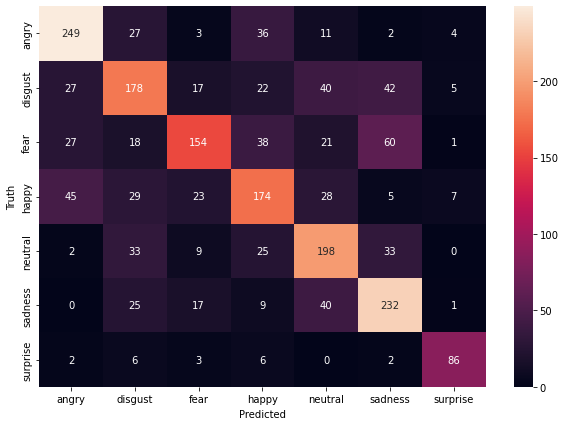

In [508]:
y_pred = svc.predict(x_test)
cm = get_confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm)

<a id="rf"></a>
<h1>Random Forest</h1>

In [490]:
rf = RandomForestClassifier()
model_scores["RF"] = cross_validate(rf, scaled_features, labels, n_splits=10, verbose=1)

Completed job 0
Completed job 1
Completed job 2
Completed job 3
Completed job 4
Completed job 5
Completed job 6
Completed job 7
Completed job 8
Completed job 9


In [491]:
print("Metrics for the random forest after 10-fold cross-validation")
model_scores["RF"].mean()

Metrics for the random forest after 10-fold cross-validation


accuracy       0.625124
f1_angry       0.730227
f1_disgust     0.552251
f1_fear        0.545396
f1_happy       0.562056
f1_neutral     0.610546
f1_sadness     0.660039
f1_surprise    0.821543
f1_micro       0.625124
f1_weighted    0.621682
f1_macro       0.640294
dtype: float64

In [509]:
rf = RandomForestClassifier() # reinitializing the model
rf.fit(x_train, y_train)

RandomForestClassifier()

In [513]:
rf.feature_importances_.argsort().argsort()

array([237, 238, 239,  29,  28, 240,  20, 108,  77,  30,  24,  41,  83,
       177, 164,  90,  88, 111,  32,  70,  81, 169, 118, 107, 157,  26,
        76,  25,  21,  17, 178, 171, 116, 227,  79,  31,  19, 155, 109,
        82,  75, 188, 112,  27,  22, 154, 156, 179,  18, 141, 110, 158,
        40, 170,  38, 231,  23,  16, 159,  97, 115,  73, 176, 199, 167,
        80, 175, 225, 191,  14, 119, 173, 117, 192, 184,  15, 230,  98,
        39, 181,  91, 113, 220, 168, 120,  36, 190,  42, 186, 226, 106,
       198, 214, 105,  35,  37,  65,  10,  33,  74,  84, 166,  62, 163,
       203, 101, 187,  89,  43, 104,  87, 234,  68,   6, 139, 229, 200,
        69, 232, 222, 161,  96, 114, 183, 165,   8, 197, 140, 211, 223,
        85, 201,  57,  95, 122, 233, 185, 219, 212,  94, 160, 172, 121,
       124,  67,  86, 174,  99, 149, 202, 180, 210,  64,  52, 145, 127,
       125, 138,  78, 195,  66, 150,  60,  44,  51,  55, 236,  71,  93,
       144,  34, 193, 123, 194, 207,  54,  63, 151, 224,   9, 15

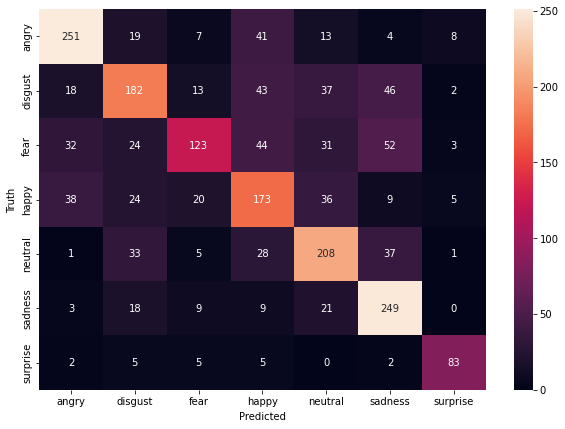

In [493]:
y_pred = rf.predict(x_test)
cm = get_confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm)

<a id="knn"></a>
<h1>K-Nearest Neighbours</h1>

In [495]:
knn = KNeighborsClassifier()
model_scores["KNN"] = cross_validate(knn, scaled_features, labels, n_splits=10, verbose=1)

Completed job 0
Completed job 1
Completed job 2
Completed job 3
Completed job 4
Completed job 5
Completed job 6
Completed job 7
Completed job 8
Completed job 9


In [496]:
print("Metrics for the n-nearest neighbours classifier after 10-fold cross-validation")
model_scores["KNN"].mean()

Metrics for the n-nearest neighbours classifier after 10-fold cross-validation


accuracy       0.552226
f1_angry       0.674873
f1_disgust     0.476223
f1_fear        0.477584
f1_happy       0.498705
f1_neutral     0.527964
f1_sadness     0.565337
f1_surprise    0.791057
f1_micro       0.552226
f1_weighted    0.551122
f1_macro       0.573106
dtype: float64

In [497]:
knn = KNeighborsClassifier() # reinitializing the model
knn.fit(x_train, y_train)

KNeighborsClassifier()

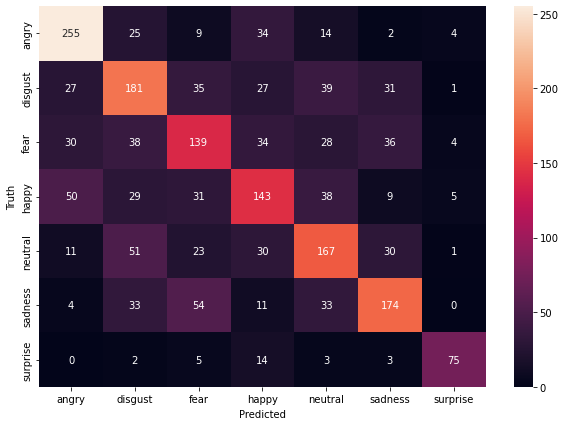

In [498]:
y_pred = knn.predict(x_test)
cm = get_confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm)

<a id="dnn"></a>
<h1>Deep neural network</h1>

In [253]:
scaled_features.shape

(10110, 241)

The input layer of the DNN will be a one-dimensional vector containing 241 features.

I now create the input pipeline using tfds.

In [267]:
EPOCHS = 100

In [401]:
# I make some modifications to the validate and cross_validate functions I made earlier to accommodate
# tensorflow models.
def validate(est, X, y, split, fold_index, verbose):
    """Fits an estimator model and evaluates its performance.
        est - Estimator/Model
        X - training data
        y - validation data
        split - tuple of indices, where the first item is the training indices; the second the validation indices.
        verbose - if set to true, print when job is complete.
    """
    x_train, y_train = X[split[0], :], y[split[0]]
    x_val, y_val = X[split[1], :], y[split[1]]
    
    # creating the tensorflow datasets from the numpy arrays.
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_ds = train_ds.shuffle(len(train_ds))
    num_train = len(train_ds)
    num_val = int(0.1*num_train)
    # I hold back some of the training data for validation when fitting the model, which is used for 
    # early stopping.
    val_ds = train_ds.take(num_val)
    train_ds = train_ds.skip(num_val)
    batch_size=64
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.shuffle(len(train_ds)).batch(batch_size).cache().prefetch(AUTOTUNE)
    val_ds = val_ds.shuffle(len(val_ds)).batch(batch_size).cache().prefetch(AUTOTUNE)
    
    # fitting the model 
    est.fit(train_ds, 
            validation_data=val_ds, 
            epochs=EPOCHS, 
            callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
           verbose=0)
    
    # making predictions
    y_pred = est.predict(x_val)
    y_pred = np.argmax(y_pred, axis=1)
    
    # computing and storing the metrics
    metrics = {}
    metrics["accuracy"] = accuracy_score(y_val, y_pred)
    # f1-scores for each individual class: returns an array
    f1_individual_scores = f1_score(y_val, y_pred, average=None) 
    for i, f1_individual_score in enumerate(f1_individual_scores):
        metrics[f"f1_{emotions[i]}"] = f1_individual_score
    # aggregates the contributions of each class, then computes the f1-score, thus not favouring any one class.
    metrics["f1_micro"] = f1_score(y_val, y_pred, average="micro") 
    # Computes the f1-score for each class, then weights them by how frequently they appeared, returning
    # a single score.
    metrics["f1_weighted"] = f1_score(y_val, y_pred, average="weighted")
    # Computes the f1-score for each class and then gets their average.
    metrics["f1_macro"] = f1_score(y_val, y_pred, average="macro") # same as f1_individual.mean()
    
    if verbose: 
        print(f"Completed job {fold_index}")
    return pd.DataFrame(metrics, index=["fold_"+str(fold_index)])

def cross_validate(est, file_name, X, y, n_splits=10, verbose=True):
    """Cross-validates an estimator for n_splits kfold stratified cross validation.
        file_name - name of the file storing the initial weights of the model, so that each
                    iteration the model is reinitialized, starting learning from scratch.
        X - features
        y - labels
        n_splits - number of folds in cross-validation.
        verbose - if set to true, prints when each validation job is complete.
    """
    # StratifiedKFOld used to ensure that the mean response value is approximately equal in each fold.
    # In simpler terms, it makes sure that the distribution of labels in each fold is somewhat equal.
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    folds = list(cv.split(scaled_features, labels))
    
    results = []
    # save initial weights so that for each iteration of cross-validation the model can be reinitialized
    path_root = "./dnn_model_weights"
    file_path = os.path.join(path_root, file_name)
    if not os.path.isdir(path_root):
        os.mkdir(path_root)
    est.save_weights(file_path)
    for fold_index, fold in enumerate(folds):
        # Loading the initial model: essentially refreshing the model.
        est.load_weights(file_path)
        results.append(validate(est, X, y, fold, fold_index, verbose))
        
    return pd.concat(results, axis=0)

In [366]:
dnn_scores = {}

<h3>Baseline</h3>

In [402]:
model = models.Sequential([
    layers.Input(shape=(241,)),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(7, activation="softmax")
])

model.summary()

model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics="accuracy"
)

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_126 (Dense)           (None, 256)               61952     
                                                                 
 dense_127 (Dense)           (None, 128)               32896     
                                                                 
 dense_128 (Dense)           (None, 7)                 903       
                                                                 
Total params: 95,751
Trainable params: 95,751
Non-trainable params: 0
_________________________________________________________________


In [403]:
# very important!!! Always create the model before calling cross_validate on the model. 
# Otherwise, the last fitted model's weights will be saved, and it will give skewed results.
dnn_scores["baseline"] = cross_validate(model, "init_baseline_model.h5", scaled_features, labels, n_splits=10, verbose=True)

Completed job 0
Completed job 1
Completed job 2
Completed job 3
Completed job 4
Completed job 5
Completed job 6
Completed job 7
Completed job 8
Completed job 9


In [415]:
print("Metrics for the baseline DNN model after 10-fold cross-validation")
dnn_scores["baseline"].mean()

Metrics for the baseline DNN model after 10-fold cross-validation


accuracy       0.635707
f1_angry       0.733290
f1_disgust     0.577879
f1_fear        0.598152
f1_happy       0.582463
f1_neutral     0.614749
f1_sadness     0.633594
f1_surprise    0.814504
f1_micro       0.635707
f1_weighted    0.634258
f1_macro       0.650662
dtype: float64

<h3>Medium size</h3>

In [405]:
model = models.Sequential([
    layers.Input(shape=(241,)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(7, activation="softmax")
])

model.summary()

model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics="accuracy"
)

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_129 (Dense)           (None, 256)               61952     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_130 (Dense)           (None, 256)               65792     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_131 (Dense)           (None, 256)               65792     
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_132 (Dense)           (None, 7)               

In [406]:
dnn_scores["medium"] = cross_validate(model, "init_medium_model.h5", scaled_features, labels, n_splits=10, verbose=True)

Completed job 0
Completed job 1
Completed job 2
Completed job 3
Completed job 4
Completed job 5
Completed job 6
Completed job 7
Completed job 8
Completed job 9


In [419]:
print("Metrics for the medium DNN model after 10-fold cross-validation")
dnn_scores["medium"].mean()

Metrics for the medium DNN model after 10-fold cross-validation


accuracy       0.656083
f1_angry       0.747512
f1_disgust     0.604522
f1_fear        0.608828
f1_happy       0.611673
f1_neutral     0.631486
f1_sadness     0.652357
f1_surprise    0.859747
f1_micro       0.656083
f1_weighted    0.655116
f1_macro       0.673732
dtype: float64

<h3>Large</h3>

In [409]:
model = models.Sequential([
    layers.Input(shape=(241,)),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(7, activation="softmax")
])

model.summary()

model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics="accuracy"
)

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_133 (Dense)           (None, 512)               123904    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_134 (Dense)           (None, 512)               262656    
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_135 (Dense)           (None, 512)               262656    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_136 (Dense)           (None, 7)               

In [410]:
dnn_scores["large"] = cross_validate(model, "init_large_model.h5", scaled_features, labels, n_splits=10, verbose=True)

Completed job 0
Completed job 1
Completed job 2
Completed job 3
Completed job 4
Completed job 5
Completed job 6
Completed job 7
Completed job 8
Completed job 9


In [418]:
print("Metrics for the large DNN model after 10-fold cross-validation")
dnn_scores["large"].mean()

Metrics for the large DNN model after 10-fold cross-validation


accuracy       0.659545
f1_angry       0.758229
f1_disgust     0.609906
f1_fear        0.608902
f1_happy       0.611089
f1_neutral     0.632270
f1_sadness     0.655922
f1_surprise    0.862736
f1_micro       0.659545
f1_weighted    0.658480
f1_macro       0.677008
dtype: float64

It seems that not much more performance can be gained with an architecture more complex than the medium DNN model.
The conclusion from all the experimentation is that the medium deep neural network with the static features is the best performing combination, achieving a micro F1-score of ≈0.66 (The large DNN model performed slightly better, but the improvement is neglible when considering the exponential increase in model size as a result of the additional neurons in each layer). I will use this as the final model and make predictions on test set using it.<br>
<br>Refer to "Final Model.ipynb" for the implementation of the final model, using it to make predictions on the test audio, and saving it to file.